In [467]:
!python -V

Python 3.8.19


In [468]:
!nvidia-smi

Wed Aug 14 13:11:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:21:00.0 Off |                  Off |
| 43%   40C    P0             53W /  450W |    3467MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# U-Net 모델을 활용한 Medical image Segmentation simulation

In [469]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from kaggle.api.kaggle_api_extended import KaggleApi
import os
os.chdir('/home/highsk88/Deeplearning_ADM/U_Nets')

# 1. 데이터셋 다운로드 및 데이터로더 생성

In [470]:
api = KaggleApi()
api.authenticate()

# 데이터셋 다운로드 및 압축 해제
dataset_path = "kaggle_lung_segmentation"
if not os.path.exists(dataset_path):
    api.dataset_download_files('kmader/finding-lungs-in-ct-data', path=dataset_path, unzip=True)

# 데이터셋 경로 설정
images_dir = os.path.join(dataset_path, "2d_images")
masks_dir = os.path.join(dataset_path, "2d_masks")

# Lung Segmentation 데이터셋을 불러오기 위한 Dataset 클래스 정의
class LungSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
        self.mask_files = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# 이미지 및 마스크 전처리 - 데이터 증강 포함
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
])

# 데이터셋 및 데이터로더 생성
dataset = LungSegmentationDataset(images_dir, masks_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# 3. U-Net 모델 정의

In [471]:
class UNetWithBatchNorm(nn.Module):
    def __init__(self):
        super(UNetWithBatchNorm, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(0.6)  
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(1, 32)  
        self.encoder2 = conv_block(32, 64)
        self.encoder3 = conv_block(64, 128)
        self.encoder4 = conv_block(128, 256)
        self.center = conv_block(256, 512)

        self.upconv4 = up_conv(512, 256)
        self.decoder4 = conv_block(512, 256)
        self.upconv3 = up_conv(256, 128)
        self.decoder3 = conv_block(256, 128)
        self.upconv2 = up_conv(128, 64)
        self.decoder2 = conv_block(128, 64)
        self.upconv1 = up_conv(64, 32)
        self.decoder1 = conv_block(64, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool2d(2)(enc3))
        center = self.center(nn.MaxPool2d(2)(enc4))

        dec4 = self.upconv4(center)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final_conv(dec1))


# 4. Loss function 정의

In [472]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

# 5. 손실 함수, 옵티마이저 및 학습률 스케줄러 정의

In [473]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetWithBatchNorm().to(device)

num_epochs = 200

criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 초기 학습률을 낮게 설정
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(train_loader), epochs=num_epochs)

# 조기 종료를 위한 초기값 설정
patience = 5
trigger_times = 0

# 모델 체크포인트 저장을 위한 초기값 설정
best_val_loss = float('inf')
best_epoch = 0

# 6. 모델 학습

In [474]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # 추가한 것
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    scheduler.step()

    # 검증 단계
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    # 모델 체크포인트 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), f'best_model_epoch_{best_epoch}.pth')
        print(f"Model checkpoint saved at epoch {best_epoch} with Val Loss: {best_val_loss:.4f}")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'Early stopping trigger times: {trigger_times}/{patience}')

    if trigger_times >= patience:
        print('Early stopping!')
        break


Epoch 1/200, Train Loss: 0.0405, Val Loss: 0.0314
Model checkpoint saved at epoch 1 with Val Loss: 0.0314
Epoch 2/200, Train Loss: 0.0271, Val Loss: 0.0240
Model checkpoint saved at epoch 2 with Val Loss: 0.0240
Epoch 3/200, Train Loss: 0.0203, Val Loss: 0.0231
Model checkpoint saved at epoch 3 with Val Loss: 0.0231
Epoch 4/200, Train Loss: 0.0185, Val Loss: 0.0242
Early stopping trigger times: 1/5
Epoch 5/200, Train Loss: 0.0169, Val Loss: 0.0265
Early stopping trigger times: 2/5
Epoch 6/200, Train Loss: 0.0157, Val Loss: 0.0284
Early stopping trigger times: 3/5
Epoch 7/200, Train Loss: 0.0150, Val Loss: 0.0270
Early stopping trigger times: 4/5
Epoch 8/200, Train Loss: 0.0137, Val Loss: 0.0351
Early stopping trigger times: 5/5
Early stopping!


# 7. 예측 결과 시각화

/var/tmp/ipykernel_2801628/3619043329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_epoch_{best_epoch}.pth'))


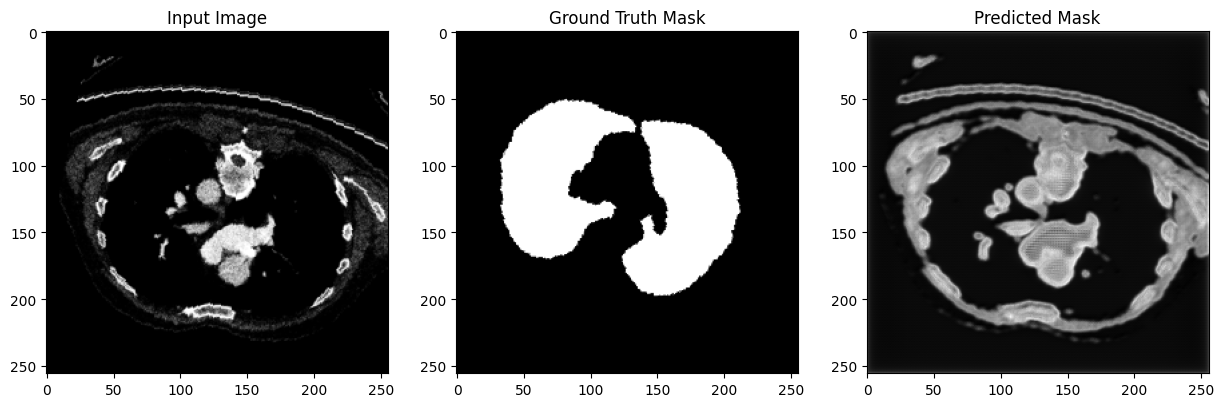

In [475]:
# 저장된 가중치 로드
best_epoch=2  # 모델 강제 설정을 위한 값 설정
model.load_state_dict(torch.load(f'best_model_epoch_{best_epoch}.pth'))
model.eval()

with torch.no_grad():
    test_index = 0
    test_img, test_mask = val_dataset[test_index]
    test_img = test_img.unsqueeze(0).to(device)  
    output = model(test_img)

    output = output.squeeze(0).squeeze(0).cpu().numpy()
    test_img = test_img.squeeze(0).squeeze(0).cpu().numpy()
    test_mask = test_mask.squeeze(0).numpy()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(test_img, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth Mask')
    plt.imshow(test_mask, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(output, cmap='gray')
    plt.show()